## Курсовой проект "Credit Default Score"

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Обзор обучающего датасета<a class="anchor" id="course_project_review"></a>

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost as xgb 

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

pd.options.display.max_columns = 100

**Пути к директориям и файлам**

In [2]:
PREP_DATASET_PATH = 'course_project_data_prep.csv' # сохранённый обучающий датасет с новыми признаками
BASE_DATASET_PATH = 'base_course_project_data_prep.csv' # с базовыми признаками после чистки данных (без новых признаков)

**Загрузка данных**

In [3]:
df_train = pd.read_csv('course_project_train.csv')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Просмотр данных**

In [4]:
df_train.shape

(7500, 17)

In [5]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Определим как каждый из признаков коррелирует с признаком 'Credit Default'**

In [7]:
corr_matrix = df_train.corr()
corr_matrix['Credit Default'].sort_values(ascending=False)

Credit Default                  1.000000
Credit Score                    0.442050
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Number of Credit Problems       0.020088
Monthly Debt                    0.018480
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Maximum Open Credit            -0.014275
Current Credit Balance         -0.019522
Years of Credit History        -0.020567
Annual Income                  -0.101375
Current Loan Amount            -0.226522
Name: Credit Default, dtype: float64

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [8]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [9]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [10]:
df_train['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

**Обзор номинативных признаков**

In [11]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка пропусков и выбросов<a class="anchor" id="gaps"></a>

In [12]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Annual Income**

In [13]:
df_train['Annual Income'].unique()

array([ 482087., 1025487.,  751412., ..., 2833185., 1257610.,  402192.])

In [14]:
A_I_0 = df_train.loc[df_train['Annual Income'].isnull(), :].index
df_train.loc[A_I_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,NaN,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,NaN,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [15]:
df_train['Annual Income'] = df_train['Annual Income'].fillna(df_train['Annual Income'].median())
df_train.loc[A_I_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,1168386.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,1168386.0,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,1168386.0,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,1168386.0,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,1168386.0,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,1168386.0,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [16]:
df_train['Annual Income'].sort_values()

4240      164597.0
4485      175845.0
3946      177251.0
3310      191577.0
1114      192223.0
           ...    
5396     8710740.0
1984     8758449.0
1025     8923844.0
2200     9338880.0
6472    10149344.0
Name: Annual Income, Length: 7500, dtype: float64

In [17]:
df_train['Annual Income'].describe()

count    7.500000e+03
mean     1.325286e+06
std      7.567551e+05
min      1.645970e+05
25%      9.311330e+05
50%      1.168386e+06
75%      1.499974e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [18]:
def annual_income(df):
    df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())
    return df

**Years in current job**

In [19]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [20]:
Years_0 = df_train.loc[df_train['Years in current job'].isnull(), :].index
df_train.loc[Years_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
24,Own Home,1168386.0,NaN,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,debt consolidation,Short Term,467676.0,818311.0,37530.0,NaN,0
58,Home Mortgage,992845.0,NaN,0.0,17.0,21.2,1132054.0,0.0,NaN,0.0,debt consolidation,Short Term,207812.0,294291.0,25483.0,739.0,0
60,Home Mortgage,1630029.0,NaN,0.0,10.0,17.3,697114.0,0.0,NaN,0.0,debt consolidation,Long Term,230362.0,260680.0,6181.0,714.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7368,Rent,408709.0,NaN,0.0,13.0,14.0,403106.0,1.0,NaN,1.0,debt consolidation,Short Term,111892.0,143773.0,3242.0,720.0,1
7409,Home Mortgage,1939349.0,NaN,0.0,10.0,17.5,322652.0,0.0,61.0,0.0,home improvements,Short Term,126720.0,56563.0,22949.0,750.0,0
7413,Rent,1784537.0,NaN,0.0,11.0,20.1,269676.0,0.0,13.0,0.0,debt consolidation,Short Term,449196.0,204250.0,22307.0,736.0,1
7439,Home Mortgage,671270.0,NaN,0.0,12.0,20.6,263406.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,151278.0,6937.0,737.0,0


In [21]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [22]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = df_train['Years in current job'].mode()[0]
df_train.loc[Years_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
22,Rent,463790.0,10+ years,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
24,Own Home,1168386.0,10+ years,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,debt consolidation,Short Term,467676.0,818311.0,37530.0,NaN,0
58,Home Mortgage,992845.0,10+ years,0.0,17.0,21.2,1132054.0,0.0,NaN,0.0,debt consolidation,Short Term,207812.0,294291.0,25483.0,739.0,0
60,Home Mortgage,1630029.0,10+ years,0.0,10.0,17.3,697114.0,0.0,NaN,0.0,debt consolidation,Long Term,230362.0,260680.0,6181.0,714.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7368,Rent,408709.0,10+ years,0.0,13.0,14.0,403106.0,1.0,NaN,1.0,debt consolidation,Short Term,111892.0,143773.0,3242.0,720.0,1
7409,Home Mortgage,1939349.0,10+ years,0.0,10.0,17.5,322652.0,0.0,61.0,0.0,home improvements,Short Term,126720.0,56563.0,22949.0,750.0,0
7413,Rent,1784537.0,10+ years,0.0,11.0,20.1,269676.0,0.0,13.0,0.0,debt consolidation,Short Term,449196.0,204250.0,22307.0,736.0,1
7439,Home Mortgage,671270.0,10+ years,0.0,12.0,20.6,263406.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,151278.0,6937.0,737.0,0


In [23]:
df_train['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [24]:
df_train['Annual Income'].describe()

count    7.500000e+03
mean     1.325286e+06
std      7.567551e+05
min      1.645970e+05
25%      9.311330e+05
50%      1.168386e+06
75%      1.499974e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [25]:
def years_in_current_job(df):
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]
    return df

**Months since last delinquent**

In [26]:
df_train['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [27]:
df_train = df_train.drop('Months since last delinquent', axis=1)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
Home Ownership               7500 non-null object
Annual Income                7500 non-null float64
Years in current job         7500 non-null object
Tax Liens                    7500 non-null float64
Number of Open Accounts      7500 non-null float64
Years of Credit History      7500 non-null float64
Maximum Open Credit          7500 non-null float64
Number of Credit Problems    7500 non-null float64
Bankruptcies                 7486 non-null float64
Purpose                      7500 non-null object
Term                         7500 non-null object
Current Loan Amount          7500 non-null float64
Current Credit Balance       7500 non-null float64
Monthly Debt                 7500 non-null float64
Credit Score                 5943 non-null float64
Credit Default               7500 non-null int64
dtypes: float64(11), int64(1), object(4)
memory usage: 937.6+ KB


In [29]:
def months_since_last_delinquent(df):
    df = df.drop('Months since last delinquent', axis=1)
    return df

**Bankruptcies**

In [30]:
df_train['Bankruptcies'].unique()

array([ 1.,  0.,  3., nan,  2.,  4.])

In [31]:
Bankruptcies_0 = df_train.loc[df_train['Bankruptcies'].isnull(), :].index
df_train.loc[Bankruptcies_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0
256,Rent,857660.0,1 year,0.0,6.0,19.7,291082.0,0.0,NaN,debt consolidation,Short Term,99999999.0,236816.0,3488.0,743.0,0
257,Home Mortgage,1168386.0,2 years,0.0,15.0,13.6,1556390.0,0.0,NaN,debt consolidation,Short Term,447480.0,524210.0,19613.0,NaN,0
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,NaN,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,0.0,0.0,NaN,other,Short Term,11242.0,0.0,1243.0,747.0,0
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,38126.0,0.0,NaN,other,Short Term,44814.0,18373.0,929.0,7490.0,1
3252,Rent,832770.0,< 1 year,0.0,7.0,16.5,636856.0,0.0,NaN,business loan,Short Term,156970.0,52250.0,1145.0,750.0,0
3351,Home Mortgage,2226192.0,8 years,0.0,14.0,23.3,792836.0,0.0,NaN,debt consolidation,Short Term,528968.0,625157.0,23746.0,674.0,0
3401,Rent,326154.0,6 years,0.0,2.0,19.1,0.0,0.0,NaN,other,Short Term,99999999.0,0.0,1245.0,712.0,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0


In [32]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [33]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]
df_train.loc[Bankruptcies_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0
256,Rent,857660.0,1 year,0.0,6.0,19.7,291082.0,0.0,0.0,debt consolidation,Short Term,99999999.0,236816.0,3488.0,743.0,0
257,Home Mortgage,1168386.0,2 years,0.0,15.0,13.6,1556390.0,0.0,0.0,debt consolidation,Short Term,447480.0,524210.0,19613.0,NaN,0
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,0.0,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,0.0,0.0,0.0,other,Short Term,11242.0,0.0,1243.0,747.0,0
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,38126.0,0.0,0.0,other,Short Term,44814.0,18373.0,929.0,7490.0,1
3252,Rent,832770.0,< 1 year,0.0,7.0,16.5,636856.0,0.0,0.0,business loan,Short Term,156970.0,52250.0,1145.0,750.0,0
3351,Home Mortgage,2226192.0,8 years,0.0,14.0,23.3,792836.0,0.0,0.0,debt consolidation,Short Term,528968.0,625157.0,23746.0,674.0,0
3401,Rent,326154.0,6 years,0.0,2.0,19.1,0.0,0.0,0.0,other,Short Term,99999999.0,0.0,1245.0,712.0,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0


In [34]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [35]:
df_train['Bankruptcies'].describe()

count    7500.000000
mean        0.116933
std         0.346904
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [36]:
def bankruptcies(df):
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]
    return df

**Credit Score**

In [37]:
list_cs = df_train['Credit Score'].unique()
list_cs.sort(axis=0)
list_cs

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

In [38]:
Credit_0 = df_train.loc[df_train['Credit Score'].isnull(), :].index
df_train.loc[Credit_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,Home Mortgage,1168386.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,Rent,1168386.0,7 years,0.0,6.0,17.8,899492.0,0.0,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,1168386.0,10+ years,0.0,14.0,30.5,645062.0,0.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7492,Home Mortgage,1168386.0,10+ years,0.0,10.0,13.3,423984.0,0.0,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,NaN,0
7494,Own Home,1168386.0,< 1 year,0.0,7.0,8.2,301554.0,0.0,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,NaN,0
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [39]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [40]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0
df_train.loc[Credit_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,0.0,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,0.0,0
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,0.0,1
10,Home Mortgage,1168386.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,0.0,0
16,Rent,1168386.0,7 years,0.0,6.0,17.8,899492.0,0.0,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,1168386.0,10+ years,0.0,14.0,30.5,645062.0,0.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,0.0,0
7492,Home Mortgage,1168386.0,10+ years,0.0,10.0,13.3,423984.0,0.0,0.0,debt consolidation,Short Term,332948.0,161481.0,20966.0,0.0,0
7494,Own Home,1168386.0,< 1 year,0.0,7.0,8.2,301554.0,0.0,0.0,debt consolidation,Short Term,290400.0,210938.0,5070.0,0.0,0
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,0.0,0


In [41]:
df_train['Credit Score'].describe()

count    7500.000000
mean      912.121733
std      1502.588014
min         0.000000
25%       667.000000
50%       722.000000
75%       740.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [42]:
def credit_score(df):
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = 0
    return df

**Current Credit Balance**

In [43]:
CCB_max = df_train.loc[df_train['Current Credit Balance'] > 5000000, :].index
df_train.loc[CCB_max, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,26343328.0,0.0,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0


In [44]:
df_train.loc[(df_train['Current Credit Balance'] > 5000000), 'Current Credit Balance'] = df_train['Current Credit Balance'].mean()
df_train.loc[CCB_max, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,26343328.0,0.0,0.0,home improvements,Short Term,757834.0,289833.2352,38023.0,703.0,0


In [45]:
CCB_0 = df_train.loc[df_train['Current Credit Balance'] == 0, :].index
df_train.loc[CCB_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0
319,Own Home,1168386.0,< 1 year,0.0,2.0,10.5,0.0,0.0,0.0,business loan,Short Term,76670.0,0.0,6432.0,0.0,0
544,Home Mortgage,1168386.0,2 years,0.0,15.0,22.5,0.0,0.0,0.0,other,Short Term,396594.0,0.0,22556.0,0.0,0
585,Home Mortgage,4772800.0,8 years,0.0,9.0,35.5,0.0,0.0,0.0,small business,Short Term,99999999.0,0.0,2227.0,747.0,0
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1163,Home Mortgage,4523064.0,3 years,0.0,6.0,14.2,0.0,0.0,0.0,home improvements,Long Term,392788.0,0.0,19902.0,690.0,0
1338,Rent,1168386.0,2 years,0.0,8.0,17.6,0.0,0.0,0.0,debt consolidation,Short Term,22176.0,0.0,12677.0,0.0,0


In [46]:
df_train.loc[df_train['Current Credit Balance'] == 0, 'Current Credit Balance'] = df_train['Current Credit Balance'].median()
df_train.loc[CCB_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,0.0,debt consolidation,Short Term,165924.0,209323.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,0.0,small business,Short Term,218042.0,209323.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,0.0,home improvements,Short Term,108042.0,209323.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,0.0,major purchase,Long Term,338096.0,209323.0,395.0,659.0,0
319,Own Home,1168386.0,< 1 year,0.0,2.0,10.5,0.0,0.0,0.0,business loan,Short Term,76670.0,209323.0,6432.0,0.0,0
544,Home Mortgage,1168386.0,2 years,0.0,15.0,22.5,0.0,0.0,0.0,other,Short Term,396594.0,209323.0,22556.0,0.0,0
585,Home Mortgage,4772800.0,8 years,0.0,9.0,35.5,0.0,0.0,0.0,small business,Short Term,99999999.0,209323.0,2227.0,747.0,0
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,0.0,home improvements,Short Term,75350.0,209323.0,0.0,704.0,0
1163,Home Mortgage,4523064.0,3 years,0.0,6.0,14.2,0.0,0.0,0.0,home improvements,Long Term,392788.0,209323.0,19902.0,690.0,0
1338,Rent,1168386.0,2 years,0.0,8.0,17.6,0.0,0.0,0.0,debt consolidation,Short Term,22176.0,209323.0,12677.0,0.0,0


In [47]:
df_train['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.904835e+05
std      3.087714e+05
min      1.900000e+01
25%      1.158288e+05
50%      2.093325e+05
75%      3.601498e+05
max      4.720132e+06
Name: Current Credit Balance, dtype: float64

In [48]:
def current_credit_balance(df):
    df.loc[(df['Current Credit Balance'] > 5000000), 'Current Credit Balance'] = df['Current Credit Balance'].mean()
    df.loc[df['Current Credit Balance'] == 0, 'Current Credit Balance'] = df['Current Credit Balance'].median()
    return df

**Monthly Debt**

In [49]:
df_train['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

In [50]:
MB_0 = df_train.loc[df_train['Monthly Debt'] == 0, :].index
df_train.loc[MB_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,0.0,home improvements,Short Term,75350.0,209323.0,0.0,704.0,0
1643,Rent,1168386.0,9 years,0.0,3.0,10.0,0.0,0.0,0.0,other,Short Term,332156.0,209323.0,0.0,0.0,1
3219,Home Mortgage,1168386.0,10+ years,0.0,3.0,18.5,0.0,0.0,0.0,debt consolidation,Short Term,79200.0,209323.0,0.0,0.0,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,educational expenses,Short Term,210166.0,209323.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,0.0,take a trip,Short Term,99999999.0,209323.0,0.0,748.0,0
7124,Rent,1168386.0,1 year,0.0,4.0,11.0,0.0,0.0,0.0,debt consolidation,Short Term,134024.0,209323.0,0.0,0.0,0


In [51]:
df_train.loc[df_train['Monthly Debt'] == 0, 'Monthly Debt'] = df_train['Monthly Debt'].median()
df_train.loc[MB_0, :]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,0.0,home improvements,Short Term,75350.0,209323.0,16076.5,704.0,0
1643,Rent,1168386.0,9 years,0.0,3.0,10.0,0.0,0.0,0.0,other,Short Term,332156.0,209323.0,16076.5,0.0,1
3219,Home Mortgage,1168386.0,10+ years,0.0,3.0,18.5,0.0,0.0,0.0,debt consolidation,Short Term,79200.0,209323.0,16076.5,0.0,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,educational expenses,Short Term,210166.0,209323.0,16076.5,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,0.0,take a trip,Short Term,99999999.0,209323.0,16076.5,748.0,0
7124,Rent,1168386.0,1 year,0.0,4.0,11.0,0.0,0.0,0.0,debt consolidation,Short Term,134024.0,209323.0,16076.5,0.0,0


In [52]:
df_train['Monthly Debt'].describe()

count      7500.000000
mean      18327.315333
std       11915.669777
min          17.000000
25%       10102.750000
50%       16077.250000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

In [53]:
def monthly_debt(df):
    df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = df['Monthly Debt'].median()
    return df

**Сохранение датасета с базовыми признаками**

In [54]:
df_train.to_csv(BASE_DATASET_PATH, index=False, encoding='utf-8')

### Построение новых признаков<a class="anchor" id="new_features"></a>

**Id**

In [55]:
df_train['ID'] = df_train.index.tolist()

In [56]:
def ID(df):
    df['ID'] = df.index.tolist()
    return df

**Dummies**

In [57]:
for cat_colname in df_train.select_dtypes(include='object').columns[:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [58]:
df_train.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)

In [59]:
def dummies(df):
    for cat_colname in df.select_dtypes(include='object').columns[:]:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    df.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)
    return df

In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 49 columns):
Home Ownership                      7500 non-null object
Annual Income                       7500 non-null float64
Years in current job                7500 non-null object
Tax Liens                           7500 non-null float64
Number of Open Accounts             7500 non-null float64
Years of Credit History             7500 non-null float64
Maximum Open Credit                 7500 non-null float64
Number of Credit Problems           7500 non-null float64
Bankruptcies                        7500 non-null float64
Purpose                             7500 non-null object
Term                                7500 non-null object
Current Loan Amount                 7500 non-null float64
Current Credit Balance              7500 non-null float64
Monthly Debt                        7500 non-null float64
Credit Score                        7500 non-null float64
Credit Default             

In [61]:
corr_matrix = df_train.corr()
corr_matrix['Credit Default'].sort_values(ascending=False)

Credit Default                      1.000000
Credit Score                        0.347105
Term_Long Term                      0.181487
Home Ownership_Rent                 0.060114
Purpose_business loan               0.042531
Purpose_small business              0.033661
Number of Open Accounts             0.028884
Purpose_renewable energy            0.026078
Tax Liens                           0.024368
Number of Credit Problems           0.020088
Monthly Debt                        0.018221
ID                                  0.012858
Years in current job_10+ years      0.012023
Home Ownership_Own Home             0.010260
Purpose_other                       0.010059
Purpose_medical bills               0.006112
Years in current job_6 years        0.005099
Bankruptcies                        0.001640
Years in current job_less 1 year    0.000432
Years in current job_1 year         0.000008
Years in current job_5 years       -0.000438
Years in current job_7 years       -0.000751
Years in c

In [62]:
len(df_train) - df_train.count()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
Credit Default                      0
ID                                  0
Home Ownership_Have Mortgage        0
Home Ownership_Home Mortgage        0
Home Ownership_Own Home             0
Home Ownership_Rent                 0
Years in current job_1 year         0
Years in current job_10+ years      0
Years in current job_2 years        0
Years in current job_3 years        0
Years in current job_4 years        0
Years in cur

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [63]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Анализ данных<a class="anchor" id="data_review"></a>

In [64]:
df_base = pd.read_csv(BASE_DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [65]:
df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Выделение целевой переменной и групп признаков**

In [66]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [67]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [68]:
NEW_FEATURE_NAMES

['ID',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

**Обзор распределения**

In [69]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 49 columns):
Home Ownership                      7500 non-null object
Annual Income                       7500 non-null float64
Years in current job                7500 non-null object
Tax Liens                           7500 non-null float64
Number of Open Accounts             7500 non-null float64
Years of Credit History             7500 non-null float64
Maximum Open Credit                 7500 non-null float64
Number of Credit Problems           7500 non-null float64
Bankruptcies                        7500 non-null float64
Purpose                             7500 non-null object
Term                                7500 non-null object
Current Loan Amount                 7500 non-null float64
Current Credit Balance              7500 non-null float64
Monthly Debt                        7500 non-null float64
Credit Score                        7500 non-null float64
Credit Default             

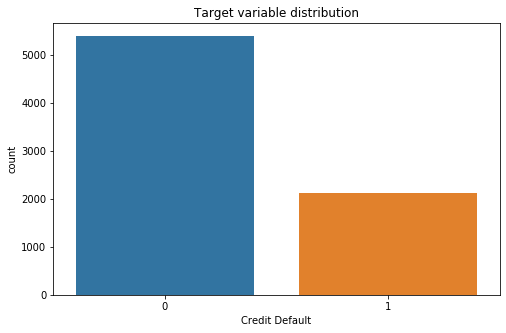

In [71]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

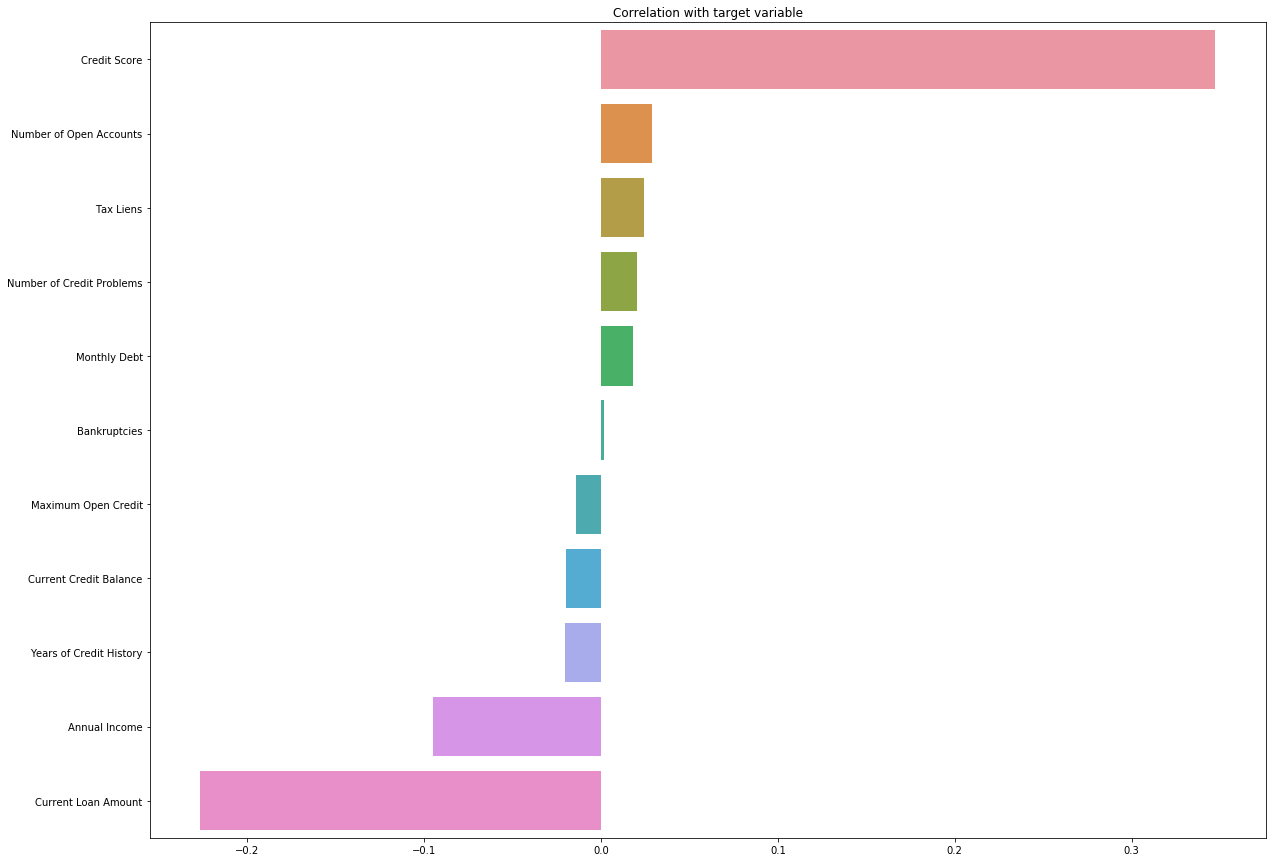

In [72]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(20, 15))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

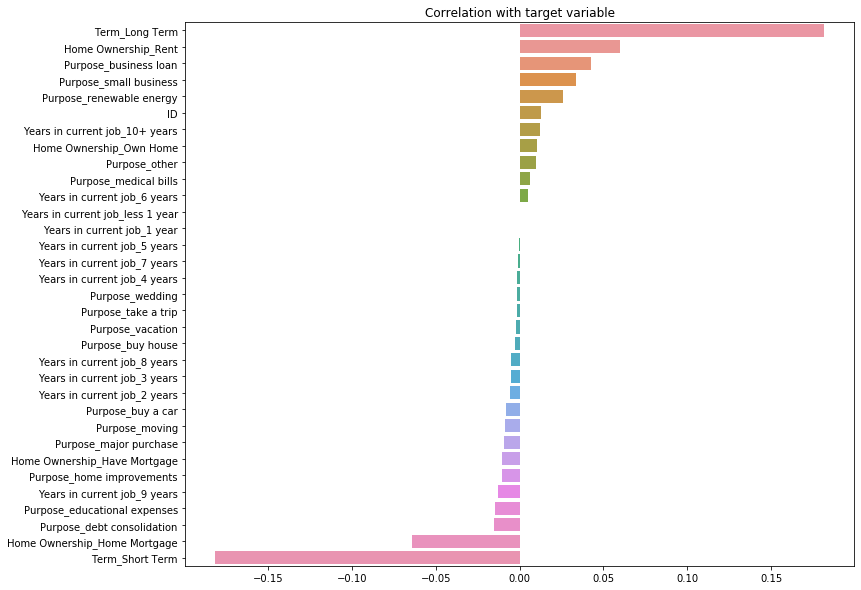

In [73]:
corr_with_target = df[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

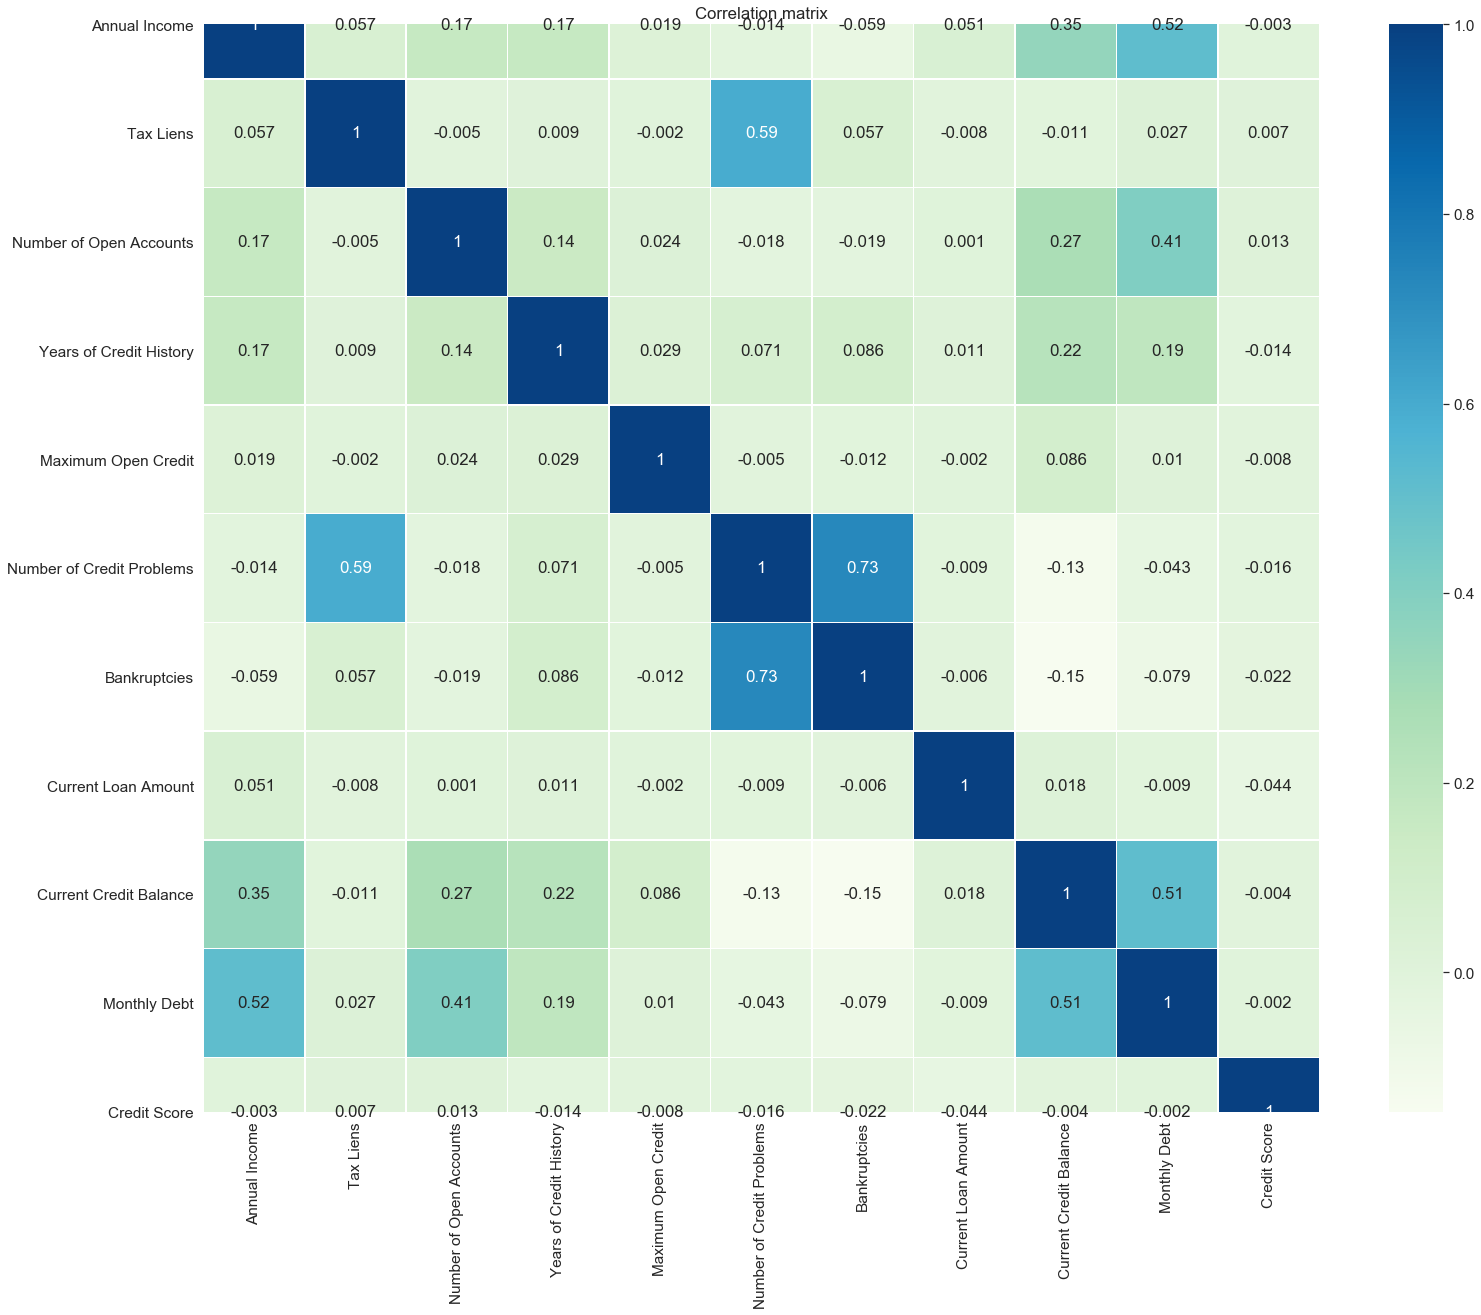

In [74]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Подключение библиотек и скриптов**

In [75]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [76]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Загрузка данных<a class="anchor" id="load_data"></a>

In [77]:
df_base = pd.read_csv(BASE_DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


**Выделение целевой переменной и групп признаков**

In [78]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [79]:
NUMERIC_FEATURE_NAMES = [
'Annual Income',
'Tax Liens',
'Number of Open Accounts',
'Years of Credit History',
'Maximum Open Credit',
'Number of Credit Problems',
#'Bankruptcies',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt',
'Credit Score'
]

In [80]:
NEW_FEATURE_NAMES = [
 'ID',
# 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
# 'Home Ownership_Own Home',
 'Home Ownership_Rent',
# 'Years in current job_1 year',
# 'Years in current job_10+ years',
# 'Years in current job_2 years',
# 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
# 'Years in current job_6 years',
# 'Years in current job_7 years',
# 'Years in current job_8 years',
 'Years in current job_9 years',
# 'Years in current job_less 1 year',
 'Purpose_business loan',
# 'Purpose_buy a car',
# 'Purpose_buy house',
 'Purpose_debt consolidation',
# 'Purpose_educational expenses',
# 'Purpose_home improvements',
# 'Purpose_major purchase',
# 'Purpose_medical bills',
# 'Purpose_moving',
# 'Purpose_other',
# 'Purpose_renewable energy',
 'Purpose_small business',
# 'Purpose_take a trip',
# 'Purpose_vacation',
# 'Purpose_wedding',
 'Term_Long Term',
# 'Term_Short Term'
]

In [81]:
FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

In [82]:
FEATURE_NAMES_SELECTED

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'ID',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Rent',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_9 years',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_small business',
 'Term_Long Term']

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [83]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.26, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [84]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3991
1    3118
Name: Credit Default, dtype: int64

In [85]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка модели<a class="anchor" id="baseline_modeling"></a> 

*XGBoost*

In [86]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1,
                              n_estimators=70, 
                              booster='gbtree',
                              random_state=21)

model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      3991
           1       0.77      0.55      0.64      3118

    accuracy                           0.73      7109
   macro avg       0.74      0.71      0.71      7109
weighted avg       0.74      0.73      0.72      7109

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1396
           1       0.57      0.51      0.54       554

    accuracy                           0.75      1950
   macro avg       0.69      0.68      0.69      1950
weighted avg       0.75      0.75      0.75      1950

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1181  215
1                269  285


**Подключение скриптов**

In [87]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [88]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [89]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [90]:
final_model = xgb.XGBClassifier(learning_rate=0.1,
                                n_estimators=70, 
                                booster='gbtree',
                                random_state=21)

final_model.fit(X_train, y_train)

y_train_predict = final_model.predict(X_train)
y_test_predict = final_model.predict(X_test)

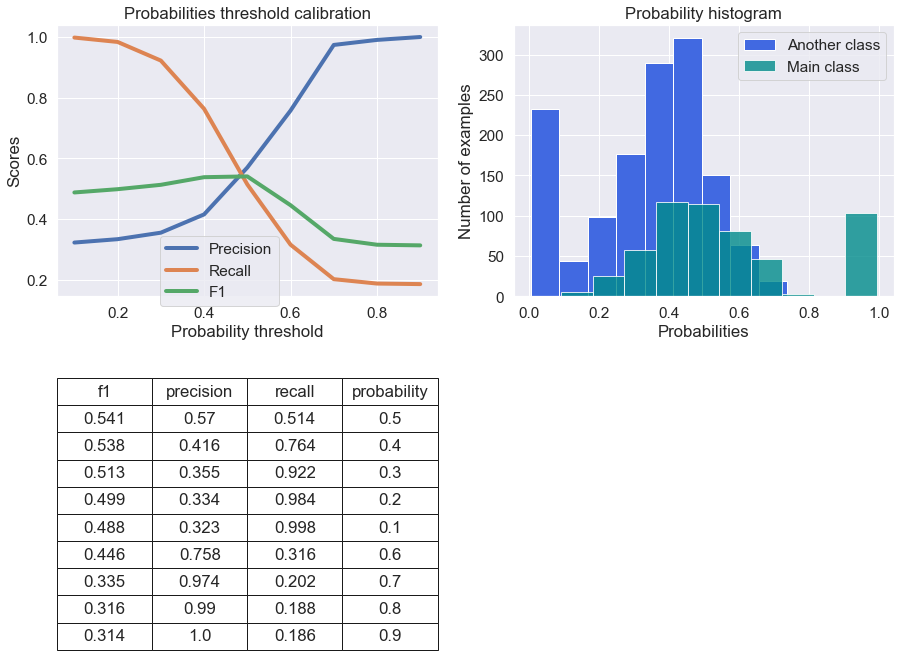

In [91]:
y_test_predict_probs = final_model.predict_proba(X_test)
show_proba_calibration_plots(y_test_predict_probs[:, 1], y_test)

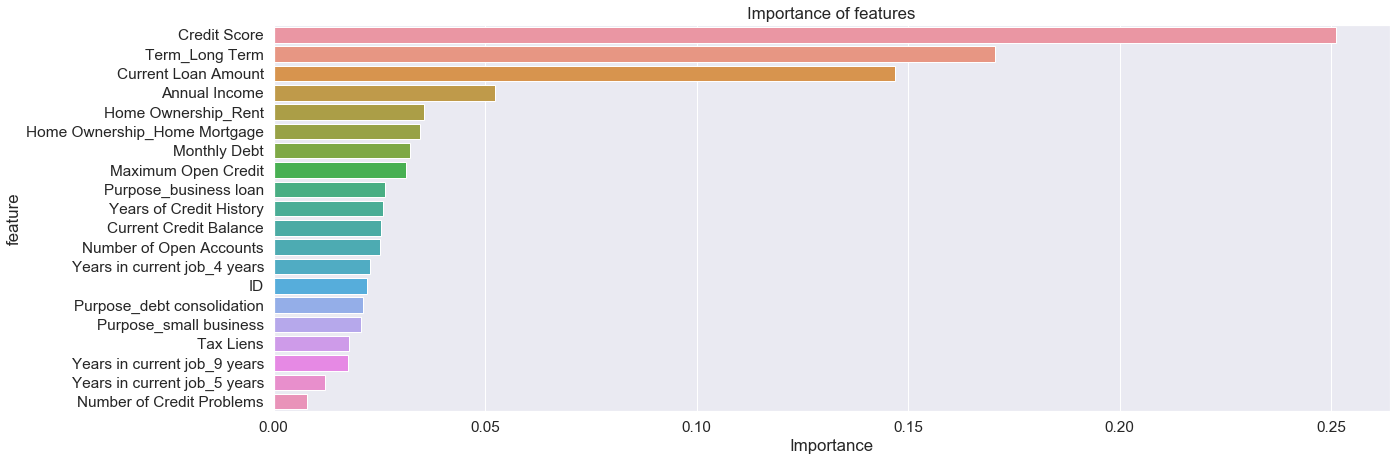

In [92]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=20)

In [93]:
important_features_top

['Credit Score',
 'Term_Long Term',
 'Current Loan Amount',
 'Annual Income',
 'Home Ownership_Rent',
 'Home Ownership_Home Mortgage',
 'Monthly Debt',
 'Maximum Open Credit',
 'Purpose_business loan',
 'Years of Credit History',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job_4 years',
 'ID',
 'Purpose_debt consolidation',
 'Purpose_small business',
 'Tax Liens',
 'Years in current job_9 years',
 'Years in current job_5 years',
 'Number of Credit Problems']

### Обработка тестового датасета<a class="anchor" id="test_dataset"></a>

In [94]:
df_test = pd.read_csv('course_project_test.csv')
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [95]:
df_test = months_since_last_delinquent(df_test)
df_test = annual_income(df_test)
df_test = years_in_current_job(df_test)
df_test = bankruptcies(df_test)
df_test = credit_score(df_test)
df_test = current_credit_balance(df_test)
df_test = monthly_debt(df_test)
df_test = ID(df_test)
df_test = dummies(df_test)

In [96]:
len(df_test) - df_test.count()

Home Ownership                      0
Annual Income                       0
Years in current job                0
Tax Liens                           0
Number of Open Accounts             0
Years of Credit History             0
Maximum Open Credit                 0
Number of Credit Problems           0
Bankruptcies                        0
Purpose                             0
Term                                0
Current Loan Amount                 0
Current Credit Balance              0
Monthly Debt                        0
Credit Score                        0
ID                                  0
Home Ownership_Have Mortgage        0
Home Ownership_Home Mortgage        0
Home Ownership_Own Home             0
Home Ownership_Rent                 0
Years in current job_1 year         0
Years in current job_10+ years      0
Years in current job_2 years        0
Years in current job_3 years        0
Years in current job_4 years        0
Years in current job_5 years        0
Years in cur

In [97]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,0.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [98]:
TEST_FEATURE_NAMES_SELECTED = FEATURE_NAMES_SELECTED

In [99]:
predicted = final_model.predict(df_test[TEST_FEATURE_NAMES_SELECTED])

In [100]:
df_pred = pd.DataFrame({'Credit Default': pd.Series(predicted, dtype='int64')})

In [101]:
df_pred.to_csv('DGerman_predictions.csv', index=False)